In [3]:
%pip install ucimlrepo
%pip install iterative-stratification
%pip install lazypredict
%pip install bayesian-optimization
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [273]:
import pandas as pd
import numpy as np

from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import xgboost as xgb
import lightgbm as lgb

from lazypredict.Supervised import LazyClassifier 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, accuracy_score, f1_score, roc_auc_score, average_precision_score
from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Data Preparation

In [239]:
def import_data():
    bank_marketing = fetch_ucirepo(id=222)
    X = bank_marketing.data.features
    y = bank_marketing.data.targets
    print(bank_marketing.metadata)
    print(bank_marketing.variables)
    df = pd.concat([X,y], axis=1)
    return df

df = import_data()

{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

In [240]:
df.isna().sum() #remove poutcome with 36959 nan
df.duplicated().sum() #no duplicated rows
df.dtypes #all seems fine
df.describe() #unbalanced dataset for personal loan and term deposit, use iterative stratification
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [241]:
def col_ohe(df, col_list): #One Hot Encoding for categorical variables
    onehotencoder = OneHotEncoder(handle_unknown='ignore', sparse_output = False)
    for var in col_list:
        var_encoded = pd.DataFrame(onehotencoder.fit_transform(df[[var]]), columns = onehotencoder.get_feature_names_out([var])).astype(int)
        df = pd.concat([df.drop(columns=var, axis=1),var_encoded], axis = 1)
    return df

def edu_ordinal(df): #Ordinal Encoding for education level
    education_encoder=OrdinalEncoder(categories=[['primary','secondary','tertiary']], handle_unknown='use_encoded_value', unknown_value=-1)
    df['education'] = education_encoder.fit_transform(df[['education']]).astype(int)
    return df

def yn_map(df, col_list): #Map binary column to numerical
    df[col_list] = df[col_list].replace({'yes':1, 'no':0})
    return df

def time_eng(df): #Add feature of days since last contact, assuming 17 Nov 2010 as last date
    start_year = 2008
    df['year'] = start_year
    df['month'] = pd.to_datetime(df['month'], format='%b').dt.month
    for i in range(1, len(df)): #data is ordered by date
        if df.loc[i, 'month'] < df.loc[i - 1, 'month']:
            df.loc[i, 'year'] = df.loc[i - 1, 'year'] + 1
        else:
            df.loc[i, 'year'] = df.loc[i - 1, 'year']
    contact_date = pd.to_datetime(df['day_of_week'].astype(str) + '-' + df['month'].astype(str) + '-' + df['year'].astype(str), format='%d-%m-%Y')
    last_contact_date = contact_date.max()
    df['days_since_contact'] = (last_contact_date - contact_date).dt.days
    df.drop(columns=['year'], inplace=True, axis=1) #dropped since did not help with models
    return df

def data_cleaning(df):
    df = col_ohe(df, ['job', 'marital', 'contact'])
    df = edu_ordinal(df)
    df = yn_map(df, ['default', 'housing', 'loan', 'y'])
    df = time_eng(df)
    df.drop(columns=['poutcome', 'duration', 'campaign', 'job_nan', 'contact_nan'], inplace=True, axis=1) #dropped campaign-related variables 
    df.rename(columns={'job_admin.': 'job_admin', 'y': 'term_deposit', 'housing': 'housing_loan', 'loan': 'personal_loan', 'month': 'last_contact_month', 'day_of_week': 'last_contact_day'}, inplace=True)
    return df

def data_split(df):
    X = df.drop(columns=['housing_loan','personal_loan','term_deposit'])
    y = df[['housing_loan','personal_loan','term_deposit']]
    mlss = MultilabelStratifiedKFold(n_splits=5, random_state=27, shuffle=True)
    train_i, test_i = next(iter(mlss.split(X, y)))
    X_train, X_test = X.iloc[train_i], X.iloc[test_i]
    y_train, y_test = y.iloc[train_i], y.iloc[test_i]
    return X_train, y_train, X_test, y_test
    
def label_split(y_train, y_test):
    hl_y_train, hl_y_test =  y_train['housing_loan'], y_test['housing_loan']
    pl_y_train, pl_y_test =  y_train['personal_loan'], y_test['personal_loan']
    td_y_train, td_y_test =  y_train['term_deposit'], y_test['term_deposit']
    return hl_y_train, hl_y_test, pl_y_train, pl_y_test, td_y_train, td_y_test

In [242]:
df = data_cleaning(df)
X_train, y_train, X_test, y_test = data_split(df)
hl_y_train, hl_y_test, pl_y_train, pl_y_test, td_y_train, td_y_test = label_split(y_train, y_test)
df.head()

,age,education,default,balance,housing_loan,personal_loan,last_contact_day,last_contact_month,pdays,previous,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,days_since_contact
0,58,2,0,2143,1,0,5,5,-1,0,...,0,0,0,0,0,1,0,0,0,926
1,44,1,0,29,1,0,5,5,-1,0,...,0,0,1,0,0,0,1,0,0,926
2,33,1,0,2,1,1,5,5,-1,0,...,0,0,0,0,0,1,0,0,0,926
3,47,-1,0,1506,1,0,5,5,-1,0,...,0,0,0,0,0,1,0,0,0,926
4,33,-1,0,1,0,0,5,5,-1,0,...,0,0,0,0,0,0,1,0,0,926


# One vs Many Approach
## Housing Loan
### Model Selection

In [214]:
lazy_search = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
hl_models,hl_predictions = lazy_search.fit(X_train, X_test, hl_y_train, hl_y_test)
print(hl_models)

100%|█████████████████████████████████████████████████████████████████████████████████| 29/29 [56:38<00:00, 117.19s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.80               0.80     0.80      0.80   
XGBClassifier                      0.80               0.80     0.80      0.80   
RandomForestClassifier             0.78               0.78     0.78      0.78   
AdaBoostClassifier                 0.77               0.77     0.77      0.77   
BaggingClassifier                  0.77               0.77     0.77      0.77   
NuSVC                              0.76               0.76     0.76      0.76   
ExtraTreesClassifier               0.76               0.76     0.76      0.76   
SVC                                0.74               0.73     0.73      0.74   
KNeighborsClassifier               0.73               0.73     0.73      0.73   
LabelSpreading                     0.72               0.72     0.72      0.72   
LabelPropagation            

From the above results, gradient boosting models work the best to predict housing loan for the data. Since Light Gradient Boosting Model(LGBM) and XGBoost have similar performance, LGBM is chosen for efficiency.
### Hyperparameter Tuning

In [149]:
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=27,n_estimators=10000, output_process=False):
    train_data = lgb.Dataset(data=X_train, label=y, free_raw_data=False)
    
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf, min_sum_hessian_in_leaf, lambda_l2):
        params = {
            'application':'binary',
            'metric':'auc',
            'learning_rate' : max(min(learning_rate, 1), 0), #efficient convergence
            "num_leaves" : int(round(num_leaves)), #controls complexity
            'feature_fraction' : max(min(feature_fraction, 1), 0), #dropout for feature
            'bagging_fraction' : max(min(bagging_fraction, 1), 0), #dropout for data
            'max_depth' : int(round(max_depth)), #prevent overfitting
            'max_bin' : int(round(max_bin)), #controls bin for continuous variables
            'min_data_in_leaf' : int(round(min_data_in_leaf)), #prevent overfitting
            'min_sum_hessian_in_leaf' : min_sum_hessian_in_leaf, #control complexity
            'lambda_l2' : lambda_l2, #regularisation for overfitting
            'verbose' : -1 #mute message
        }

        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, metrics=['auc'])
        return max(cv_result['valid auc-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.001, 0.7),
                                            'num_leaves': (5, 100),
                                            'feature_fraction': (0.1, 1),
                                            'bagging_fraction': (0.1, 1),
                                            'max_depth': (3, 20),
                                            'max_bin':(50,700),
                                            'min_data_in_leaf': (5,70),
                                            'min_sum_hessian_in_leaf':(0,1),
                                            'lambda_l2':(0,10)}, 
                                            random_state=27)
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
        
    print(f"Validation AUROC:{lgbBO.res[pd.Series(model_auc).idxmax()]['target']:.5f} ")
    return lgbBO.res[pd.Series(model_auc).idxmax()]['params']

def get_lgb_opt_params(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=27,n_estimators=10000, output_process=False):
    opt_params=bayes_parameter_opt_lgb(X, y, init_round, opt_round, n_folds, random_seed,n_estimators, output_process)
    opt_params["num_leaves"] = int(round(opt_params["num_leaves"]))
    opt_params['max_depth'] = int(round(opt_params['max_depth']))
    opt_params['min_data_in_leaf'] = int(round(opt_params['min_data_in_leaf']))
    opt_params['max_bin'] = int(round(opt_params['max_bin']))
    opt_params['objective'] = 'binary'
    opt_params['metric'] = ['auc','aucpr', 'binary_error']
    opt_params['early_stopping_rounds'] = 50
    opt_params['random_state'] = 27
    return opt_params

In [150]:
hl_opt_params = get_lgb_opt_params(X_train, hl_y_train, init_round=10, opt_round=15, n_folds=5, random_seed=27,n_estimators=10000)
hl_opt_params

|   iter    |  target   | baggin... | featur... | lambda_l2 | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.863     | 0.4831    | 0.8331    | 7.354     | 0.6077    | 299.2     | 19.65     | 63.06     | 0.2097    | 75.47     |
| 2         | 0.8654    | 0.6968    | 0.8981    | 8.58      | 0.5247    | 615.6     | 6.175     | 26.16     | 0.3729    | 80.4      |
| 3         | 0.8652    | 0.236     | 0.2529    | 0.8117    | 0.2143    | 559.1     | 5.769     | 9.592     | 0.7011    | 22.19     |
| 4         | 0.8683    | 0.639     | 0.4737    | 5.136     | 0.1552    | 521.6     | 17.44     | 65.38     | 0.7359    | 50.28     |
| 5         | 0.8686    | 0.5436    | 0.6351    | 0.7604    | 0.08312   | 678.2     | 12.92     | 11.01     | 0.01363   | 84.51     |
| 6         | 0.8647    | 0.9233    | 0.7341    | 3.87      | 

{'bagging_fraction': 0.5436036759336191,
 'feature_fraction': 0.6350682445913682,
 'lambda_l2': 0.7603696537169113,
 'learning_rate': 0.08311636662252349,
 'max_bin': 678,
 'max_depth': 13,
 'min_data_in_leaf': 11,
 'min_sum_hessian_in_leaf': 0.013629501631003293,
 'num_leaves': 85,
 'objective': 'binary',
 'metric': ['auc', 'aucpr', 'binary_error'],
 'early_stopping_rounds': 50,
 'random_state': 27}

### Evaluation

In [229]:
def get_biz_threshold(y_test, y_pred_prob, cost=1, profit=1): #profit is lost profit due to false negative customer and cost is cost of marketing to a false positive customer
    fpr, tpr, ths = roc_curve(y_test, y_pred_prob)
    fnr = 1 - tpr
    pos_n = sum(y_test)  
    neg_n = len(y_test) - pos_n
    biz_loss = (fnr * profit * pos_n) + (fpr * cost * neg_n) #number of positive and negative used as weights for imbalanced data set
    return np.min(biz_loss), ths[np.argmin(biz_loss)] #outputs the minimum business loss and threshold

def lgb_impl(X_train, y_train, X_test, y_test, opt_params, cost=1, profit=1):
    mod = lgb.train(opt_params, lgb.Dataset(X_train, label=y_train), valid_sets=(lgb.Dataset(X_test, label=y_test),))
    y_pred_prob = mod.predict(X_test, num_iteration=mod.best_iteration)
    min_biz_loss, ths = get_biz_threshold(y_test, y_pred_prob, cost, profit)
    y_pred = (y_pred_prob > ths).astype(int)  
    return y_pred_prob, y_pred

def mod_eval(y_test, y_pred_prob, y_pred):  
    acc = accuracy_score(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_pred_prob)
    f1 = f1_score(y_test, y_pred)
    auprc = average_precision_score(y_test, y_pred_prob)
    prc_b = len(y_test[y_test == 1]) / len(y_test)
    print(f"Test Accuracy: {acc:.5f} | Test AUROC: {auroc:.5f} | Test F1: {f1:.5f} | Test AUPRC: {auprc:.5f}(baseline:{prc_b:.5f})")
    return acc, auroc, f1, auprc, prc_b

In [230]:
hl_y_pred_prob, hl_y_pred = lgb_impl(X_train, hl_y_train, X_test, hl_y_test, hl_opt_params, cost=1, profit=2.5)
hl_acc, hl_auroc, hl_f1, hl_auprc, hl_prc_b = mod_eval(hl_y_test, hl_y_pred_prob, hl_y_pred)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.877895	valid_0's binary_error: 0.196749
Test Accuracy: 0.78047 | Test AUROC: 0.87789 | Test F1: 0.81959 | Test AUPRC: 0.89435(baseline:0.55585)


In [156]:
hl_lgbm = lgb.train(hl_opt_params, lgb.Dataset(X_train, label=hl_y_train), valid_sets=(lgb.Dataset(X_test, label=hl_y_test),))
hl_y_pred_prob = hl_lgbm.predict(X_test,  num_iteration=hl_lgbm.best_iteration)
hl_y_pred = (hl_y_pred_prob > get_threshold(hl_y_test, hl_y_pred_prob, cost=1, profit=2.5)).astype(int)  
hl_acc = accuracy_score(hl_y_test, hl_y_pred)
hl_auroc = roc_auc_score(hl_y_test, hl_y_pred_prob)
hl_f1 = f1_score(hl_y_test, hl_y_pred)
hl_auprc = average_precision_score(hl_y_test, hl_y_pred_prob)
hl_prc_b = len(df[df['housing_loan'] == 1]) / len(df)
print(f"Test Accuracy: {hl_acc:.5f} | Test AUROC: {hl_auroc:.5f} | Test F1: {hl_f1:.5f} | Test AUPRC: {hl_auprc:.5f}(baseline:{hl_prc_b: .5f})")
print(confusion_matrix(hl_y_test, hl_y_pred))

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.877895	valid_0's binary_error: 0.196749
Test Accuracy: 0.78047 | Test AUROC: 0.87789 | Test F1: 0.81959 | Test AUPRC: 0.89435(baseline: 0.55584)
[[2548 1468]
 [ 517 4509]]


### Analysis

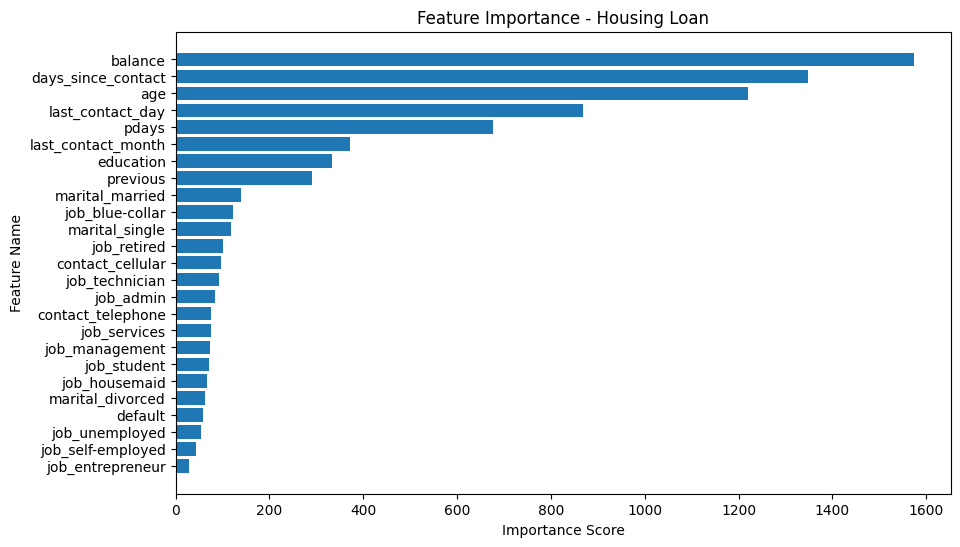

In [98]:
hl_impt = hl_lgbm.feature_importance()
hl_impt_df = pd.DataFrame({'Feature': hl_lgbm.feature_name(), 'Importance': hl_impt}).sort_values(by='Importance', ascending=True)
plt.figure(figsize=(10, 6))
plt.barh(hl_impt_df['Feature'], hl_impt_df['Importance'])
plt.title('Feature Importance - Housing Loan')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.show()

In [238]:
df.describe()

,age,education,default,balance,housing_loan,personal_loan,last_contact_day,last_contact_month,pdays,previous,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,days_since_contact
count,45211.00,45211.00,45211.00,45211.00,45211.00,45211.00,45211.00,45211.00,45211.00,45211.00,...,45211.00,45211.00,45211.00,45211.00,45211.00,45211.00,45211.00,45211.00,45211.00,45211.00
mean,40.94,1.06,0.02,1362.27,0.56,0.16,15.81,6.14,40.20,0.58,...,0.09,0.02,0.17,0.03,0.12,0.60,0.28,0.65,0.06,717.51
std,10.62,0.78,0.13,3044.77,0.50,0.37,8.32,2.41,100.13,2.30,...,0.29,0.14,0.37,0.17,0.32,0.49,0.45,0.48,0.25,203.24
min,18.00,-1.00,0.00,-8019.00,0.00,0.00,1.00,1.00,-1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,33.00,1.00,0.00,72.00,0.00,0.00,8.00,5.00,-1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,566.00
50%,39.00,1.00,0.00,448.00,1.00,0.00,16.00,6.00,-1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,817.00
75%,48.00,2.00,0.00,1428.00,1.00,0.00,21.00,8.00,-1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,882.00
max,95.00,2.00,1.00,102127.00,1.00,1.00,31.00,12.00,871.00,275.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,926.00


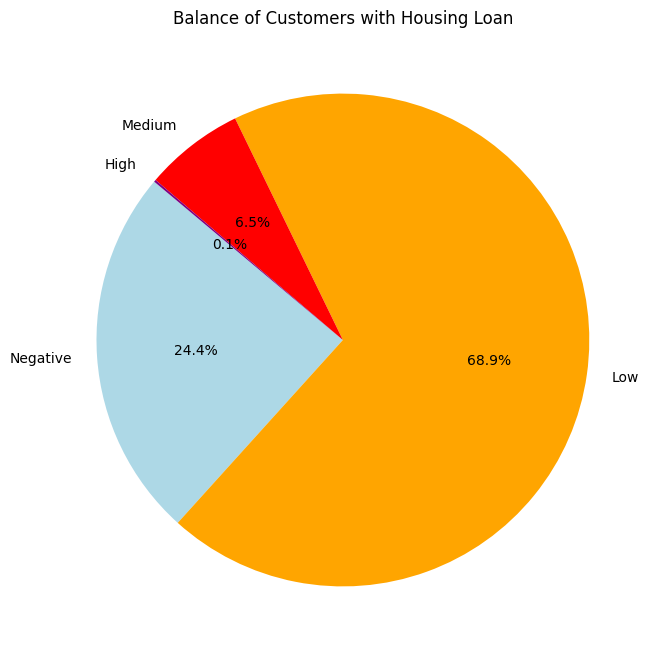

In [254]:
bal_bins = [df['balance'].min(), 0, 3000, 20000, df['balance'].max()]
bal_labs = ['Negative', 'Low', 'Medium', 'High']
df['bal_cat'] = pd.cut(df['balance'], bins=bal_bins, labels=bal_labs, include_lowest=True)
hl_cus = df[df['housing_loan'] == 1]
hl_bal_cat_counts = hl_cus['bal_cat'].value_counts().sort_index()

plt.figure(figsize=(8, 8))
plt.pie(bal_cat_counts, labels=bal_cat_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'orange', 'red', 'purple'])
plt.title("Balance of Customers with Housing Loan")
plt.show()

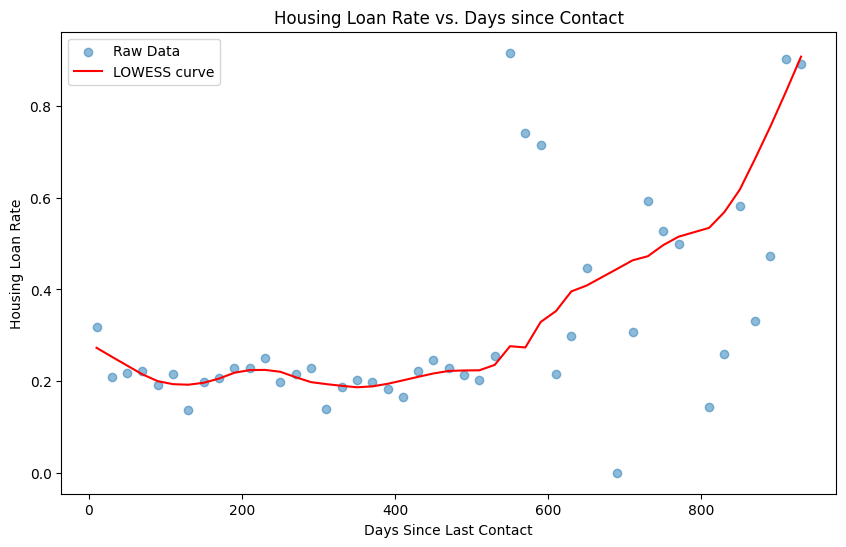

In [280]:
df['days_bin'] = pd.cut(df['days_since_contact'], bins=range(0, df['days_since_contact'].max() + 20, 20))
hl_rate = df.groupby('days_bin')['housing_loan'].mean().reset_index()
hl_rate['bin_mid'] = hl_rate['days_bin'].apply(lambda x: x.mid)
smoothed = lowess(hl_rate['housing_loan'], hl_rate['bin_mid'], frac=0.2)

plt.figure(figsize=(10, 6))
plt.scatter(hl_rate['bin_mid'], hl_rate['housing_loan'], alpha=0.5, label="Raw Data")
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', label="LOWESS curve")
plt.xlabel("Days Since Last Contact")
plt.ylabel("Housing Loan Rate")
plt.title("Housing Loan Rate vs. Days since Contact")
plt.legend()
plt.show()

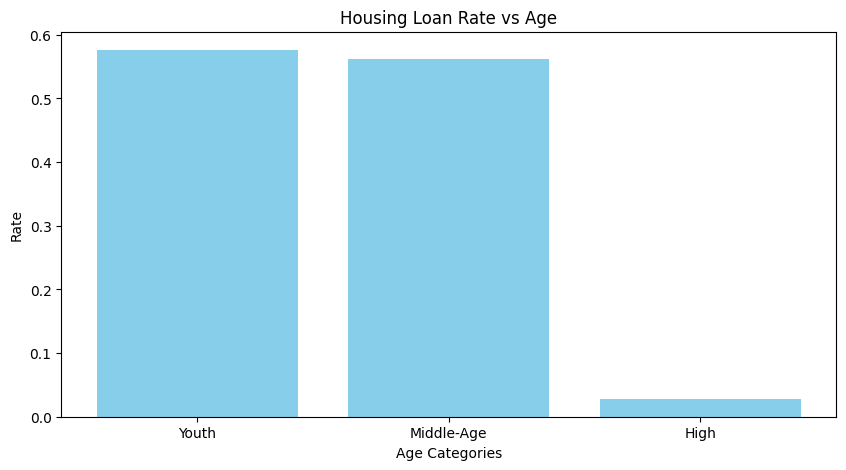

In [246]:
age_bins = [df['age'].min(), 30, 65, df['balance'].max()]
age_labels = ['Youth', 'Middle-Age', 'High']
df['age_cat'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, include_lowest=True)
hl_rate = df.groupby('age_cat')['housing_loan'].mean()

plt.figure(figsize=(10,5))
plt.bar(hl_rate.index, hl_rate.values, color='skyblue')
plt.xticks(ticks=range(0, 3), labels=age_labels)
plt.xlabel("Age Categories")
plt.ylabel("Rate")
plt.title("Housing Loan Rate vs Age")

# Show plot
plt.show()


The target group for housing loans are youths and middle age customers with lower bank balance, this corresponds with the business understanding that the youths and middle age are more likely to buy new houses and loans are generally for customers lacking funding for their new houses. It is recommended to suggest housing loan to these target groups to increase success rate.
## Personal Loan
### Model Selection

In [41]:
lazy_search = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
pl_models,pl_predictions = lazy_search.fit(X_train, X_test, pl_y_train, pl_y_test)
print(pl_models)

 97%|███████████████████████████████████████████████████████████████████████████████▏  | 28/29 [08:49<00:31, 31.11s/it]

[LightGBM] [Info] Number of positive: 5795, number of negative: 30374
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160220 -> initscore=-1.656592
[LightGBM] [Info] Start training from score -1.656592


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [08:49<00:00, 18.26s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.56               0.58     0.58      0.62   
GaussianNB                         0.53               0.57     0.57      0.59   
QuadraticDiscriminantAnalysis      0.32               0.56     0.56      0.34   
DecisionTreeClassifier             0.75               0.55     0.55      0.75   
ExtraTreeClassifier                0.75               0.54     0.54      0.75   
ExtraTreesClassifier               0.81               0.54     0.54      0.78   
RandomForestClassifier             0.83               0.54     0.54      0.79   
XGBClassifier                      0.84               0.54     0.54      0.79   
BaggingClassifier                  0.82               0.54     0.54      0.78   
KNeighborsClassifier               0.82               0.53     0.53      0.78   
LGBMClassifier              

XGBoost chosen since it gives the best results as shown above.
### Hyperparameter Tuning

In [191]:
def bayes_parameter_opt_xgb(X, y, label, init_round=15, opt_round=25, n_folds=3, random_seed=27,n_estimators=10000, output_process=False):
    train_data = xgb.DMatrix(X, label=y)
    
    def xgb_eval(learning_rate, max_depth, subsample, colsample_bytree, reg_lambda, reg_alpha, min_child_weight, gamma):
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'aucpr',  
            'learning_rate': max(min(learning_rate, 1), 0), #efficient convergence
            'max_depth': int(round(max_depth)), #prevent overfitting
            'subsample': max(min(subsample, 1), 0), #prevent overfitting
            'colsample_bytree': max(min(colsample_bytree, 1), 0), #prevent overfitting
            'reg_lambda': max(reg_lambda, 0), #l2 regularisation for complexity
            'reg_alpha': max(reg_alpha, 0), #l1 regularisation for complexity
            'min_child_weight': max(min_child_weight, 0), #control complexity
            'gamma': max(gamma, 0), #control complexity
            'verbosity': 1, #mute message
            'scale_pos_weight':len(df[df[label] == 0]) / len(df[df[label] == 1]) #weight for imbalanced data
        }

        cv_result = xgb.cv(params, train_data, num_boost_round=n_estimators, nfold=n_folds, seed=random_seed, stratified=True)
        return max(cv_result['test-aucpr-mean'])
     
    xgbBO = BayesianOptimization(xgb_eval, {'learning_rate': (0.001, 0.7), 
                                            'max_depth': (3, 20), 
                                            'subsample': (0.1, 1.0),
                                            'colsample_bytree': (0.1, 1.0),
                                            'reg_lambda': (0, 10),
                                            'reg_alpha': (0, 10),
                                            'min_child_weight': (0, 10),
                                            'gamma': (0, 10)}, 
                                            random_state=27)
    
    xgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len( xgbBO.res)):
        model_auc.append(xgbBO.res[model]['target'])
    
    print(f"Validation AUPRC:{xgbBO.res[pd.Series(model_auc).idxmax()]['target']:.5f} ")
    return xgbBO.res[pd.Series(model_auc).idxmax()]['params']

def get_xgb_opt_params(X, y, label, init_round=15, opt_round=25, n_folds=3, random_seed=27,n_estimators=10000, output_process=False):
    opt_params=bayes_parameter_opt_xgb(X, y, label, init_round, opt_round, n_folds, random_seed,n_estimators, output_process) 
    opt_params['max_depth'] = int(round(opt_params['max_depth']))
    opt_params['objective'] = 'binary:logistic'  
    opt_params['eval_metric'] = ['aucpr']
    opt_params['random_state'] = 27
    return opt_params

In [39]:
pl_opt_params = get_xgb_opt_params(X_train, pl_y_train, 'personal_loan',init_round=5, opt_round=10, n_folds=3, random_seed=27,n_estimators=10000)
pl_opt_params

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.3104    | 0.4831    | 8.146     | 0.515     | 17.76     | 3.834     | 9.795     | 8.932     | 0.2887    |
| 2         | 0.3058    | 0.7676    | 6.631     | 0.6209    | 17.59     | 7.493     | 8.701     | 1.868     | 0.393     |
| 3         | 0.321     | 0.4356    | 7.937     | 0.1066    | 5.889     | 0.8117    | 3.052     | 7.833     | 0.2466    |
| 4         | 0.3249    | 0.1636    | 7.011     | 0.1275    | 13.18     | 4.153     | 5.136     | 2.207     | 0.753     |
| 5         | 0.2953    | 0.8645    | 9.289     | 0.5154    | 11.1      | 4.929     | 5.945     | 0.7604    | 0.2057    |
| 6         | 0.3161    | 0.7024    | 7.825     | 0.2132    | 5.644     | 0.9518    | 3.449     | 8.259     | 0.2299    |
| 7         | 0.3049    

{'colsample_bytree': 0.6281982507677273,
 'gamma': 7.893772986546304,
 'learning_rate': 0.15099355435566217,
 'max_depth': 5,
 'min_child_weight': 0.266886079288865,
 'reg_alpha': 2.4504076812212494,
 'reg_lambda': 7.6974043195909285,
 'subsample': 0.8266454238259481,
 'objective': 'binary:logistic',
 'eval_metric': ['aucpr'],
 'random_state': 27}

### Evaluation

In [200]:
def xgb_impl(X_train, y_train, X_test, y_test, opt_params, cost=1, profit=1):
    mod = xgb.train(opt_params, xgb.DMatrix(X_train, label=y_train), evals=[(xgb.DMatrix(X_test, label=td_y_test),'test')], num_boost_round = 1000, early_stopping_rounds = 25)
    y_pred_prob = mod.predict(xgb.DMatrix(X_test, label=pl_y_test))
    min_biz_loss, ths = get_biz_threshold(y_test, y_pred_prob, cost, profit)
    y_pred = (y_pred_prob > ths).astype(int)  
    return y_pred_prob, y_pred

In [231]:
pl_y_pred_prob, pl_y_pred = xgb_impl(X_train, pl_y_train, X_test, pl_y_test, pl_opt_params, cost=1, profit=2)
pl_acc, pl_auroc, pl_f1, pl_auprc, pl_prc_b = mod_eval(pl_y_test, pl_y_pred_prob, pl_y_pred)

[0]	test-aucpr:0.08028
[1]	test-aucpr:0.07939
[2]	test-aucpr:0.07851
[3]	test-aucpr:0.07862
[4]	test-aucpr:0.07880
[5]	test-aucpr:0.07894
[6]	test-aucpr:0.07901
[7]	test-aucpr:0.07992
[8]	test-aucpr:0.08002
[9]	test-aucpr:0.07943
[10]	test-aucpr:0.07956
[11]	test-aucpr:0.07960
[12]	test-aucpr:0.07959
[13]	test-aucpr:0.07997
[14]	test-aucpr:0.07996
[15]	test-aucpr:0.08004
[16]	test-aucpr:0.08025
[17]	test-aucpr:0.08019
[18]	test-aucpr:0.08041
[19]	test-aucpr:0.08006
[20]	test-aucpr:0.08013
[21]	test-aucpr:0.08025
[22]	test-aucpr:0.08033
[23]	test-aucpr:0.08025
[24]	test-aucpr:0.08033
[25]	test-aucpr:0.08040
[26]	test-aucpr:0.08052
[27]	test-aucpr:0.08025
[28]	test-aucpr:0.08038
[29]	test-aucpr:0.08059
[30]	test-aucpr:0.08058
[31]	test-aucpr:0.08065
[32]	test-aucpr:0.08058
[33]	test-aucpr:0.08060
[34]	test-aucpr:0.08059
[35]	test-aucpr:0.08059
[36]	test-aucpr:0.08059
[37]	test-aucpr:0.08059
[38]	test-aucpr:0.08072
[39]	test-aucpr:0.08072
[40]	test-aucpr:0.08072
[41]	test-aucpr:0.08078
[4

### Analysis

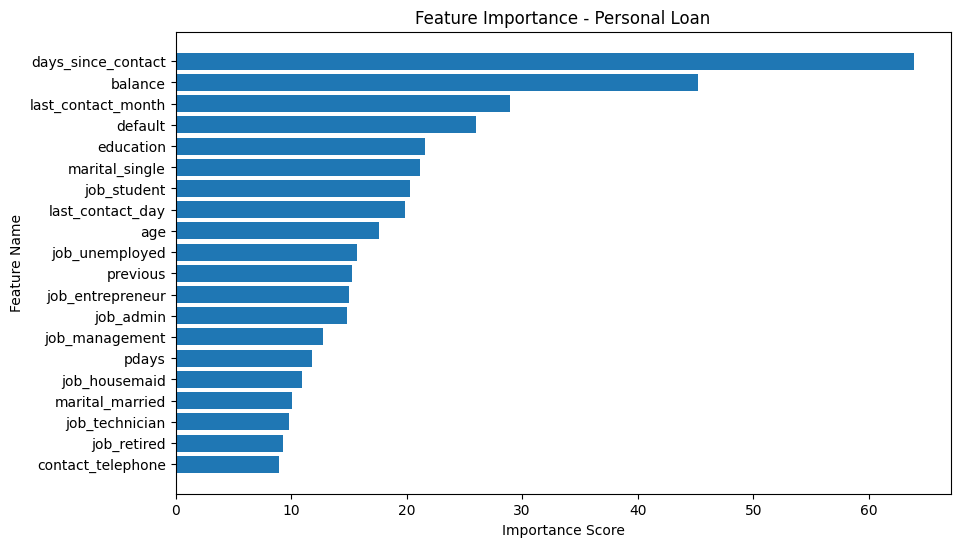

In [111]:
pl_impt = pl_xgb.get_score(importance_type='gain')
pl_impt_df = pd.DataFrame({'Feature': list(pl_impt.keys()), 'Importance': list(pl_impt.values())}).sort_values(by='Importance', ascending=True)
plt.figure(figsize=(10, 6))
plt.barh(pl_impt_df['Feature'], pl_impt_df['Importance'])
plt.title('Feature Importance - Personal Loan')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.show()

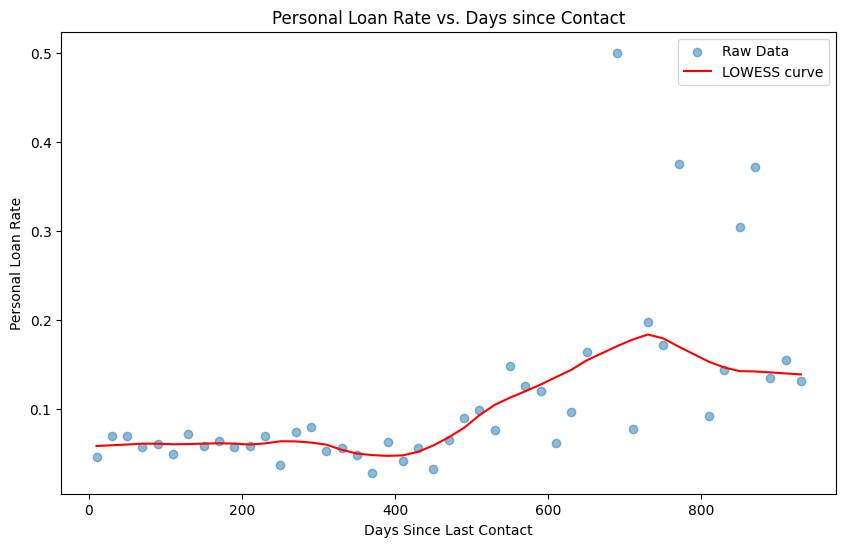

In [279]:
df['days_bin'] = pd.cut(df['days_since_contact'], bins=range(0, df['days_since_contact'].max() + 20, 20))
hl_rate = df.groupby('days_bin')['personal_loan'].mean().reset_index()
hl_rate['bin_mid'] = hl_rate['days_bin'].apply(lambda x: x.mid)
smoothed = lowess(hl_rate['personal_loan'], hl_rate['bin_mid'], frac=0.2)

plt.figure(figsize=(10, 6))
plt.scatter(hl_rate['bin_mid'], hl_rate['personal_loan'], alpha=0.5, label="Raw Data")
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', label="LOWESS curve")
plt.xlabel("Days Since Last Contact")
plt.ylabel("Personal Loan Rate")
plt.title("Personal Loan Rate vs. Days since Contact")
plt.legend()
plt.show()

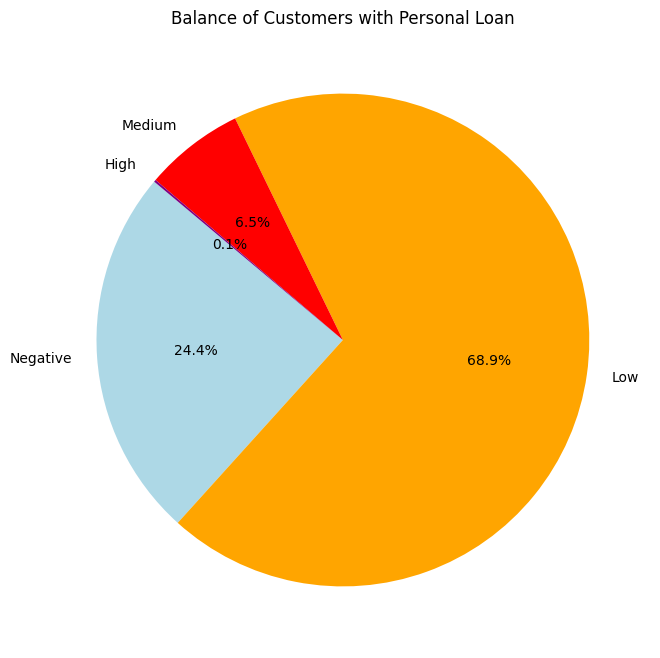

In [255]:
pl_cus = df[df['personal_loan'] == 1]
pl_bal_cat_counts = pl_cus['bal_cat'].value_counts().sort_index()

plt.figure(figsize=(8, 8))
plt.pie(bal_cat_counts, labels=bal_cat_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'orange', 'red', 'purple'])
plt.title("Balance of Customers with Personal Loan")
plt.show()

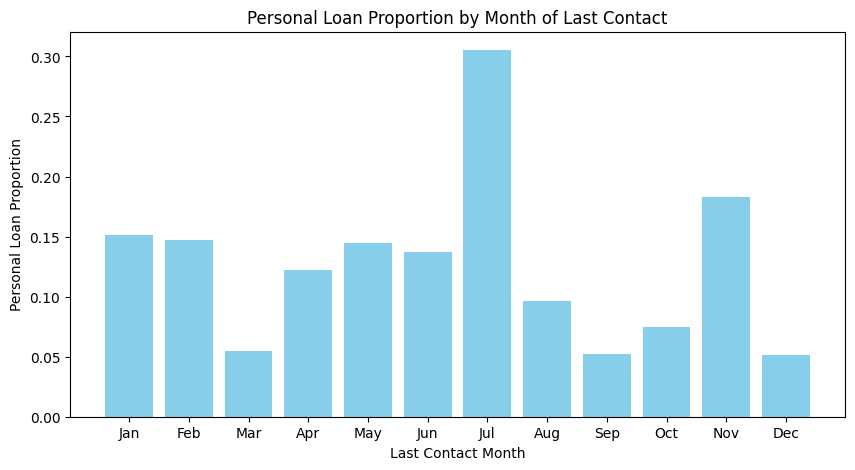

In [251]:
mth_labs = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
pl_rate = df.groupby('last_contact_month')['personal_loan'].mean()

plt.figure(figsize=(10,5))
plt.bar(pl_rate.index, pl_rate.values, color='skyblue')
plt.xticks(ticks=range(1, 13), labels=mth_labs)
plt.xlabel("Last Contact Month")
plt.ylabel("Personal Loan Proportion")
plt.show()

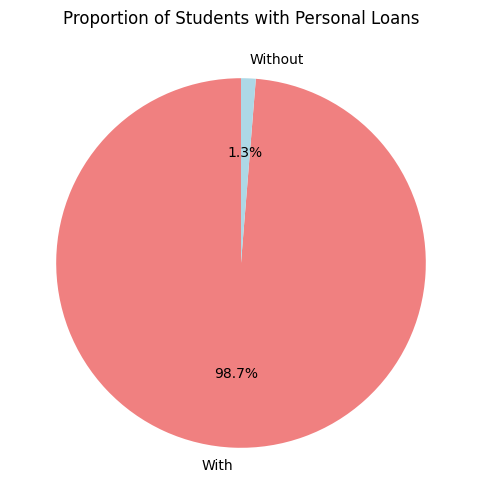

In [258]:
stu_cus = df[df['job_student'] == 1]
pl_stu_counts = stu_cus['personal_loan'].value_counts()
stu_labs = ['With', 'Without']

plt.figure(figsize=(6, 6))
plt.pie(pl_stu_counts, labels=stu_labs, autopct='%1.1f%%', colors=['lightcoral', 'lightblue'], startangle=90)
plt.title("Proportion of Students with Personal Loans")
plt.show()

The target group of personal loan is customers with low bank balance and special groups such as students are more inclined to take personal loans due to financial circumstances. There is also seasonal trend with July having the highest personal loan adoption proportion so it is recommended to reach out to customers about personal loans during months of higher proportion for a higher success rate.
## Term Deposit
### Model Selection

In [42]:
lazy_search = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
td_models,td_predictions = lazy_search.fit(X_train, X_test, td_y_train, td_y_test)
print(td_models)

 97%|███████████████████████████████████████████████████████████████████████████████▏  | 28/29 [06:02<00:12, 12.76s/it]

[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117006 -> initscore=-2.021091
[LightGBM] [Info] Start training from score -2.021091


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [06:02<00:00, 12.50s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
CalibratedClassifierCV             0.85               0.70     0.70      0.86   
NearestCentroid                    0.73               0.69     0.69      0.77   
QuadraticDiscriminantAnalysis      0.73               0.68     0.68      0.77   
Perceptron                         0.81               0.67     0.67      0.83   
PassiveAggressiveClassifier        0.84               0.66     0.66      0.84   
XGBClassifier                      0.89               0.63     0.63      0.88   
GaussianNB                         0.81               0.63     0.63      0.82   
LGBMClassifier                     0.89               0.62     0.62      0.87   
LinearDiscriminantAnalysis         0.88               0.62     0.62      0.87   
RandomForestClassifier             0.89               0.62     0.62      0.87   
DecisionTreeClassifier      

### Hyperparameter Tuning

In [97]:
td_opt_params = get_xgb_opt_params(X_train, td_y_train, 'term_deposit', init_round=5, opt_round=10, n_folds=3, random_seed=27,n_estimators=10000)
td_opt_params

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.4018    | 0.4831    | 8.146     | 0.515     | 17.76     | 3.834     | 9.795     | 8.932     | 0.2887    |
| 2         | 0.4014    | 0.7676    | 6.631     | 0.6209    | 17.59     | 7.493     | 8.701     | 1.868     | 0.393     |
| 3         | 0.4297    | 0.4356    | 7.937     | 0.1066    | 5.889     | 0.8117    | 3.052     | 7.833     | 0.2466    |
| 4         | 0.4375    | 0.1636    | 7.011     | 0.1275    | 13.18     | 4.153     | 5.136     | 2.207     | 0.753     |
| 5         | 0.3957    | 0.8645    | 9.289     | 0.5154    | 11.1      | 4.929     | 5.945     | 0.7604    | 0.2057    |
| 6         | 0.4163    | 0.7024    | 7.825     | 0.2132    | 5.644     | 0.9518    | 3.449     | 8.259     | 0.2299    |
| 7         | 0.4118    

{'colsample_bytree': 0.4157942248802582,
 'gamma': 6.3755371156668526,
 'learning_rate': 0.05582075825068678,
 'max_depth': 13,
 'min_child_weight': 4.415522445961107,
 'reg_alpha': 6.740077939792876,
 'reg_lambda': 2.394036323235528,
 'subsample': 0.8215037183327571,
 'objective': 'binary:logistic',
 'eval_metric': ['aucpr'],
 'random_state': 27}

### Evaluation

In [204]:
td_y_pred_prob, td_y_pred = xgb_impl(X_train, td_y_train, X_test, td_y_test, td_opt_params, cost=1, profit=2)
td_acc, td_auroc, td_f1, td_auprc, td_prc_b = mod_eval(td_y_test, td_y_pred_prob, td_y_pred)

[0]	test-aucpr:0.39128
[1]	test-aucpr:0.37312
[2]	test-aucpr:0.38489
[3]	test-aucpr:0.38057
[4]	test-aucpr:0.38477
[5]	test-aucpr:0.38903
[6]	test-aucpr:0.39007
[7]	test-aucpr:0.39049
[8]	test-aucpr:0.38959
[9]	test-aucpr:0.39307
[10]	test-aucpr:0.39379
[11]	test-aucpr:0.39486
[12]	test-aucpr:0.39609
[13]	test-aucpr:0.39546
[14]	test-aucpr:0.39690
[15]	test-aucpr:0.39725
[16]	test-aucpr:0.39577
[17]	test-aucpr:0.39555
[18]	test-aucpr:0.39562
[19]	test-aucpr:0.39435
[20]	test-aucpr:0.39503
[21]	test-aucpr:0.39508
[22]	test-aucpr:0.39555
[23]	test-aucpr:0.39543
[24]	test-aucpr:0.39697
[25]	test-aucpr:0.39692
[26]	test-aucpr:0.39643
[27]	test-aucpr:0.39620
[28]	test-aucpr:0.39679
[29]	test-aucpr:0.39604
[30]	test-aucpr:0.39614
[31]	test-aucpr:0.39521
[32]	test-aucpr:0.39500
[33]	test-aucpr:0.39402
[34]	test-aucpr:0.39396
[35]	test-aucpr:0.39493
[36]	test-aucpr:0.39608
[37]	test-aucpr:0.39826
[38]	test-aucpr:0.39912
[39]	test-aucpr:0.39932
[40]	test-aucpr:0.39898
[41]	test-aucpr:0.39931
[4

### Analysis

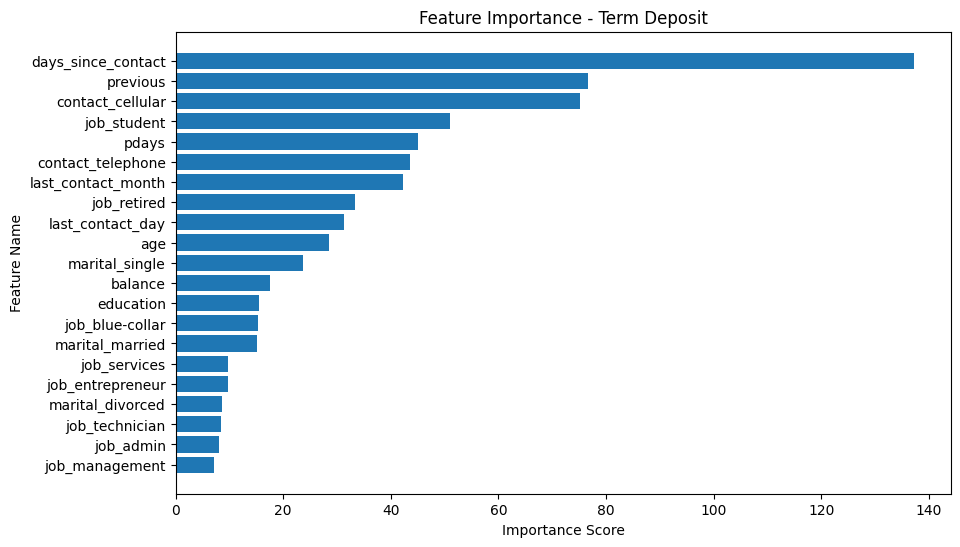

In [105]:
td_impt = td_xgb.get_score(importance_type='gain')
td_impt_df = pd.DataFrame({'Feature': list(td_impt.keys()), 'Importance': list(td_impt.values())}).sort_values(by='Importance', ascending=True)
plt.figure(figsize=(10, 6))
plt.barh(td_impt_df['Feature'], td_impt_df['Importance'])
plt.title('Feature Importance - Term Deposit')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.show()

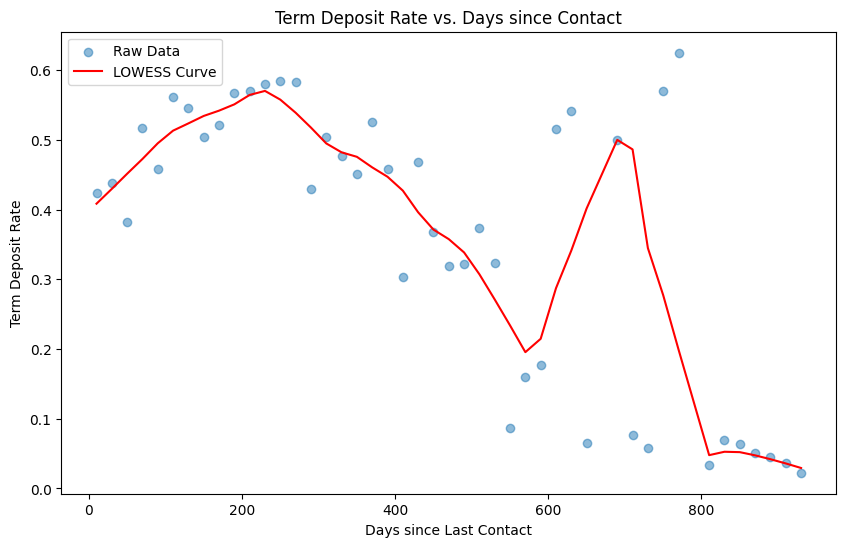

In [36]:
df['days_bin'] = pd.cut(df['days_since_contact'], bins=range(0, df['days_since_contact'].max() + 20, 20))
td_rate = df.groupby('days_bin')['term_deposit'].mean().reset_index()
td_rate['bin_mid'] = td_rate['days_bin'].apply(lambda x: x.mid)
smoothed = lowess(td_rate['term_deposit'], td_rate['bin_mid'], frac=0.2)

plt.figure(figsize=(10, 6))
plt.scatter(td_rate['bin_mid'], td_rate['term_deposit'], alpha=0.5, label="Raw Data")
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', label="LOWESS Curve")
plt.xlabel("Days since Last Contact")
plt.ylabel("Term Deposit Rate")
plt.title("Term Deposit Rate vs. Days since Contact")
plt.legend()
plt.show()

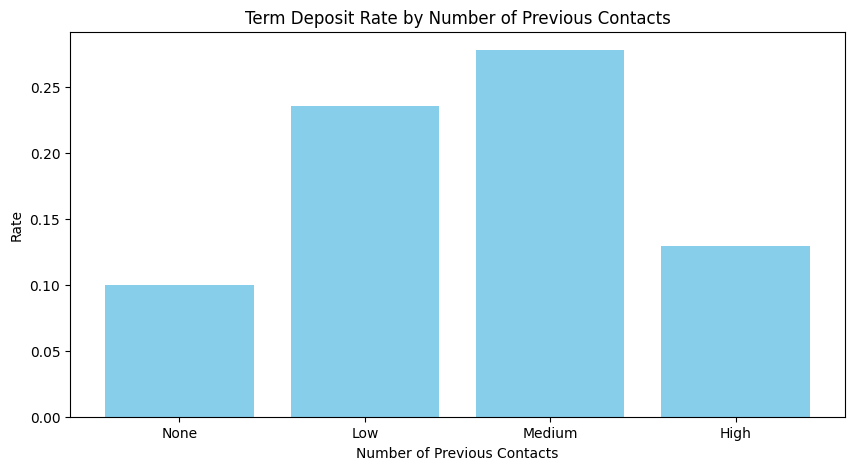

In [265]:
prev_bins = [df['previous'].min(), 1, 5, 15, df['previous'].max()]
prev_labs = ['None', 'Low', 'Medium', 'High']
df['prev_cat'] = pd.cut(df['previous'], bins=prev_bins, labels=prev_labs, include_lowest=True)
td_rate = df.groupby('prev_cat')['term_deposit'].mean()

plt.figure(figsize=(10,5))
plt.bar(td_rate.index, td_rate.values, color='skyblue')
plt.xticks(ticks=range(0, 4), labels=prev_labs)
plt.xlabel("Number of Previous Contacts")
plt.ylabel("Rate")
plt.title("Term Deposit Rate by Number of Previous Contacts")
plt.show()

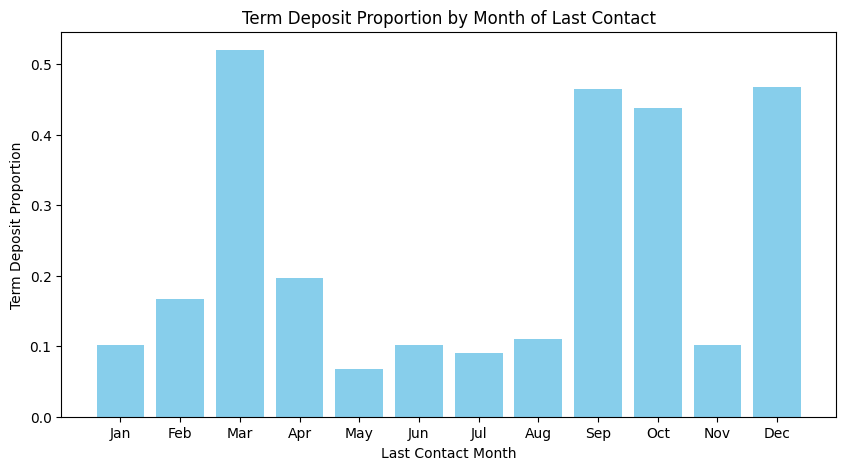

In [266]:
td_rate = df.groupby('last_contact_month')['term_deposit'].mean()

plt.figure(figsize=(10,5))
plt.bar(td_rate.index, td_rate.values, color='skyblue')
plt.xticks(ticks=range(1, 13), labels=mth_labs)
plt.xlabel("Last Contact Month")
plt.ylabel("Term Deposit Proportion")
plt.title("Term Deposit Proportion by Month of Last Contact")

# Show plot
plt.show()

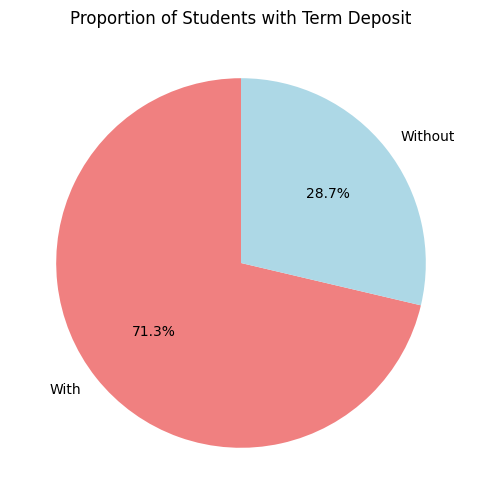

In [272]:
stu_cus = df[df['job_student'] == 1]
pl_stu_counts = stu_cus['term_deposit'].value_counts()
stu_labs = ['With', 'Without']

plt.figure(figsize=(6, 6))
plt.pie(pl_stu_counts, labels=stu_labs, autopct='%1.1f%%', colors=['lightcoral', 'lightblue'], startangle=90)
plt.title("Proportion of Students with Term Deposit")
plt.show()

The subsciption of term deposit is closely tied to the contacts the customers received with a general decrease in subscriptions across day since last contact and general increase of subscription with increased frequency of contact. It is recommended to contact the customers after a short period since subscription increase initially with day since last contact and with appropriate frequency since subscription rate drops drastically after 15 contacts. Contacting customers during peak subscription months like March, September, etc. can increase success rates.
## Final Model

In [277]:
def final_classification_model(X_train, y_train, X_test, y_test):
    hl_y_train, hl_y_test, pl_y_train, pl_y_test, td_y_train, td_y_test = label_split(y_train, y_test)
    print("Housing Loan:")
    hl_opt_params = {'bagging_fraction': 0.5436036759336191,
                     'feature_fraction': 0.6350682445913682,
                     'lambda_l2': 0.7603696537169113,
                     'learning_rate': 0.08311636662252349,
                     'max_bin': 678,
                     'max_depth': 13,
                     'min_data_in_leaf': 11,
                     'min_sum_hessian_in_leaf': 0.013629501631003293,
                     'num_leaves': 85,
                     'objective': 'binary',
                     'metric': ['auc', 'aucpr', 'binary_error'],
                     'early_stopping_rounds': 50,
                     'random_state': 27}
    hl_y_pred_prob, hl_y_pred = lgb_impl(X_train, hl_y_train, X_test, hl_y_test, hl_opt_params, cost=1, profit=2.5)
    hl_acc, hl_auroc, hl_f1, hl_auprc, hl_prc_b = mod_eval(hl_y_test, hl_y_pred_prob, hl_y_pred)
    
    print("Personal Loan:")
    pl_opt_params = {'colsample_bytree': 0.6281982507677273,
                     'gamma': 7.893772986546304,
                     'learning_rate': 0.15099355435566217,
                     'max_depth': 5,
                     'min_child_weight': 0.266886079288865,
                     'reg_alpha': 2.4504076812212494,
                     'reg_lambda': 7.6974043195909285,
                     'subsample': 0.8266454238259481,
                     'objective': 'binary:logistic',
                     'eval_metric': ['aucpr'],
                     'random_state': 27}
    pl_y_pred_prob, pl_y_pred = xgb_impl(X_train, pl_y_train, X_test, pl_y_test, pl_opt_params, cost=1, profit=2)
    pl_acc, pl_auroc, pl_f1, pl_auprc, pl_prc_b = mod_eval(pl_y_test, pl_y_pred_prob, pl_y_pred)

    print("Term Deposit:")
    td_opt_params = {'colsample_bytree': 0.4157942248802582,
                     'gamma': 6.3755371156668526,
                     'learning_rate': 0.05582075825068678,
                     'max_depth': 13,
                     'min_child_weight': 4.415522445961107,
                     'reg_alpha': 6.740077939792876,
                     'reg_lambda': 2.394036323235528,
                     'subsample': 0.8215037183327571,
                     'objective': 'binary:logistic',
                     'eval_metric': ['aucpr'],
                     'random_state': 27}
    td_y_pred_prob, td_y_pred = xgb_impl(X_train, td_y_train, X_test, td_y_test, td_opt_params, cost=1, profit=2)
    td_acc, td_auroc, td_f1, td_auprc, td_prc_b = mod_eval(td_y_test, td_y_pred_prob, td_y_pred)

    print("Overall:")
    y_pred_prob = np.column_stack((hl_y_pred_prob, pl_y_pred_prob, td_y_pred_prob))
    y_pred = np.column_stack((hl_y_pred, pl_y_pred, td_y_pred))
    fin_acc = (hl_acc + pl_acc + td_acc)/3
    fin_auroc = (hl_auroc + pl_auroc + td_auroc)/3
    fin_f1 = (hl_f1 + pl_f1 + td_f1)/3
    fin_auprc = (hl_auprc + pl_auprc + td_auprc)/3
    fin_prc_b = (hl_prc_b + pl_prc_b + td_prc_b)/3
    print(f"Test Accuracy: {fin_acc:.5f} | Test AUROC: {fin_auroc:.5f} | Test F1: {fin_f1:.5f} | Test AUPRC: {fin_auprc:.5f}(baseline:{fin_prc_b:.5f})")
    return y_pred_prob, y_pred

def final_recommendation_model(y_pred_prob):
    scaler = MinMaxScaler()
    norm_y_pred_probs = pd.DataFrame(scaler.fit_transform(y_pred_prob), columns=["Housing Loan", "Personal Loan", "Term Deposit"]) #normalise the probabilities across results of different models
    ranks = norm_y_pred_probs.apply(lambda x: x.rank(method="first", ascending=False), axis=1) #the higher probabilities will be ranked higher to recommend
    return ranks    

In [278]:
y_pred_prob, y_pred = final_model(X_train, y_train, X_test, y_test)
ranks = final_recommendation_model(y_pred_prob)
print(ranks)

Housing Loan:
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.877895	valid_0's binary_error: 0.196749
Test Accuracy: 0.78047 | Test AUROC: 0.87789 | Test F1: 0.81959 | Test AUPRC: 0.89435(baseline:0.55585)
Personal Loan:
[0]	test-aucpr:0.08028
[1]	test-aucpr:0.07939
[2]	test-aucpr:0.07851
[3]	test-aucpr:0.07862
[4]	test-aucpr:0.07880
[5]	test-aucpr:0.07894
[6]	test-aucpr:0.07901
[7]	test-aucpr:0.07992
[8]	test-aucpr:0.08002
[9]	test-aucpr:0.07943
[10]	test-aucpr:0.07956
[11]	test-aucpr:0.07960
[12]	test-aucpr:0.07959
[13]	test-aucpr:0.07997
[14]	test-aucpr:0.07996
[15]	test-aucpr:0.08004
[16]	test-aucpr:0.08025
[17]	test-aucpr:0.08019
[18]	test-aucpr:0.08041
[19]	test-aucpr:0.08006
[20]	test-aucpr:0.08013
[21]	test-aucpr:0.08025
[22]	test-aucpr:0.08033
[23]	test-aucpr:0.08025
[24]	test-aucpr:0.08033
[25]	test-aucpr:0.08040
[26]	test-aucpr:0.08052
[27]	test-aucpr:0.08025
[28]	test-aucpr:0.08038
[29]	test-